# WildfireSpreadTS Embeddings Exploration

This notebook explores the CNN embeddings extracted from WildfireSpreadTS imagery.

**Embeddings Info:**
- Source: ResNet50 pretrained on ImageNet
- Dimension: 2048 features per image
- Format: Parquet file with embeddings + metadata

**Goals:**
1. Understand embedding structure and dimensions
2. Analyze embedding statistics and distributions
3. Explore metadata (dates, event IDs, filenames)
4. Check data quality (missing values, duplicates)
5. Visualize embedding patterns


In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set paths
PROJECT_ROOT = Path().resolve().parent
INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
EMBEDDINGS_PATH = INTERIM_DIR / "wildfirespreadts_embeddings.parquet"

print(f"Embeddings path: {EMBEDDINGS_PATH}")
print(f"File exists: {EMBEDDINGS_PATH.exists()}")


Embeddings path: C:\Users\muron\Documents\ml-wildfire-risk-predictor\data\interim\wildfirespreadts_embeddings.parquet
File exists: True


## 1. Load Embeddings


In [2]:
# Load embeddings
if EMBEDDINGS_PATH.exists():
    print("Loading embeddings...")
    df = pd.read_parquet(EMBEDDINGS_PATH)
    print(f"✓ Loaded {len(df):,} rows")
    print(f"✓ {len(df.columns)} columns")
else:
    print(f"⚠️  Embeddings file not found: {EMBEDDINGS_PATH}")
    print("Please run: python src/data/extract_wildfirespreadts_embeddings.py")


Loading embeddings...
✓ Loaded 27,214 rows
✓ 2052 columns


## 2. Basic Structure


In [3]:
# Display basic info
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumn types:")
print(df.dtypes.value_counts())

print(f"\n" + "="*70)
print("COLUMN NAMES")
print("="*70)
print(f"Total columns: {len(df.columns)}")
print(f"\nFirst 20 columns: {list(df.columns[:20])}")
print(f"\nLast 10 columns: {list(df.columns[-10:])}")


DATASET OVERVIEW
Shape: (27214, 2052)
Memory usage: 217.02 MB

Column types:
float32    2048
object        4
Name: count, dtype: int64

COLUMN NAMES
Total columns: 2052

First 20 columns: ['filename', 'date', 'event_id', 'tile', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embedding_13', 'embedding_14', 'embedding_15']

Last 10 columns: ['embedding_2038', 'embedding_2039', 'embedding_2040', 'embedding_2041', 'embedding_2042', 'embedding_2043', 'embedding_2044', 'embedding_2045', 'embedding_2046', 'embedding_2047']


In [4]:
# Separate metadata and embedding columns
embedding_cols = [c for c in df.columns if c.startswith('embedding_')]
metadata_cols = [c for c in df.columns if not c.startswith('embedding_')]

print(f"Embedding columns: {len(embedding_cols)}")
print(f"Metadata columns: {len(metadata_cols)}")
print(f"\nMetadata columns: {metadata_cols}")


Embedding columns: 2048
Metadata columns: 4

Metadata columns: ['filename', 'date', 'event_id', 'tile']


## 3. Metadata Exploration


In [5]:
# Display metadata summary
print("="*70)
print("METADATA SUMMARY")
print("="*70)
print(df[metadata_cols].head(10))


METADATA SUMMARY
         filename        date event_id  tile
0  2018-01-01.tif  2018-01-01     None  None
1  2018-01-02.tif  2018-01-02     None  None
2  2018-01-03.tif  2018-01-03     None  None
3  2018-01-04.tif  2018-01-04     None  None
4  2018-01-05.tif  2018-01-05     None  None
5  2018-01-06.tif  2018-01-06     None  None
6  2018-01-07.tif  2018-01-07     None  None
7  2018-01-08.tif  2018-01-08     None  None
8  2018-01-09.tif  2018-01-09     None  None
9  2018-01-10.tif  2018-01-10     None  None


In [6]:
# Check for date information
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    print("Date information:")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Valid dates: {df['date'].notna().sum():,} / {len(df):,}")
    
    # Date distribution
    if df['date'].notna().sum() > 0:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        
        print(f"\nYear distribution:")
        print(df['year'].value_counts().sort_index())
        
        print(f"\nMonth distribution:")
        print(df['month'].value_counts().sort_index())
else:
    print("No date column found")


Date information:
  Date range: 2017-12-29 00:00:00 to 2021-11-08 00:00:00
  Valid dates: 27,214 / 27,214

Year distribution:
year
2017       6
2018    7540
2019    2850
2020    8584
2021    8234
Name: count, dtype: int64

Month distribution:
month
1      344
2      342
3      242
4      472
5      802
6     2644
7     5484
8     8702
9     5644
10    1578
11     820
12     140
Name: count, dtype: int64


In [7]:
# Check event IDs
if 'event_id' in df.columns:
    print(f"Unique event IDs: {df['event_id'].nunique():,}")
    print(f"\nTop 10 events by image count:")
    print(df['event_id'].value_counts().head(10))
else:
    print("No event_id column found")


Unique event IDs: 0

Top 10 events by image count:
Series([], Name: count, dtype: int64)


In [8]:
# Filename patterns
if 'filename' in df.columns:
    print(f"Total filenames: {df['filename'].nunique():,}")
    print(f"\nSample filenames:")
    print(df['filename'].head(10).tolist())
    
    # Check for duplicates
    duplicates = df['filename'].duplicated().sum()
    print(f"\nDuplicate filenames: {duplicates}")
    if duplicates > 0:
        print("\nDuplicate examples:")
        print(df[df['filename'].duplicated(keep=False)]['filename'].head(10))


Total filenames: 1,120

Sample filenames:
['2018-01-01.tif', '2018-01-02.tif', '2018-01-03.tif', '2018-01-04.tif', '2018-01-05.tif', '2018-01-06.tif', '2018-01-07.tif', '2018-01-08.tif', '2018-01-09.tif', '2018-01-10.tif']

Duplicate filenames: 26094

Duplicate examples:
0    2018-01-01.tif
1    2018-01-02.tif
2    2018-01-03.tif
3    2018-01-04.tif
4    2018-01-05.tif
5    2018-01-06.tif
6    2018-01-07.tif
7    2018-01-08.tif
8    2018-01-09.tif
9    2018-01-10.tif
Name: filename, dtype: object


## 4. Embedding Statistics


In [9]:
# Extract embedding matrix
embedding_matrix = df[embedding_cols].values
print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Expected: ({len(df)}, 2048)")


Embedding matrix shape: (27214, 2048)
Expected: (27214, 2048)


In [10]:
# Basic statistics
print("="*70)
print("EMBEDDING STATISTICS")
print("="*70)
print(f"Min: {embedding_matrix.min():.4f}")
print(f"Max: {embedding_matrix.max():.4f}")
print(f"Mean: {embedding_matrix.mean():.4f}")
print(f"Std: {embedding_matrix.std():.4f}")
print(f"\nPer-dimension statistics (first 10 dimensions):")
for i in range(min(10, len(embedding_cols))):
    col = embedding_cols[i]
    print(f"  {col}: mean={df[col].mean():.4f}, std={df[col].std():.4f}, min={df[col].min():.4f}, max={df[col].max():.4f}")


EMBEDDING STATISTICS
Min: 0.0000
Max: 7.6501
Mean: 0.2279
Std: 0.3703

Per-dimension statistics (first 10 dimensions):
  embedding_0: mean=0.0641, std=0.0687, min=0.0000, max=0.9518
  embedding_1: mean=0.3242, std=0.2341, min=0.0000, max=2.0635
  embedding_2: mean=0.0763, std=0.0873, min=0.0000, max=1.0578
  embedding_3: mean=0.0907, std=0.1213, min=0.0000, max=1.0172
  embedding_4: mean=0.0465, std=0.1030, min=0.0000, max=1.4820
  embedding_5: mean=0.1185, std=0.1429, min=0.0000, max=1.9562
  embedding_6: mean=0.3518, std=0.2494, min=0.0000, max=2.0670
  embedding_7: mean=0.3129, std=0.2295, min=0.0000, max=1.6364
  embedding_8: mean=0.0670, std=0.0874, min=0.0000, max=0.8656
  embedding_9: mean=0.0636, std=0.0851, min=0.0000, max=0.9083


In [11]:
# Check for missing values
missing = df[embedding_cols].isna().sum().sum()
print(f"Missing values in embeddings: {missing:,}")
if missing > 0:
    print("\nColumns with missing values:")
    missing_cols = df[embedding_cols].isna().sum()
    print(missing_cols[missing_cols > 0])
else:
    print("✓ No missing values in embeddings")


Missing values in embeddings: 0
✓ No missing values in embeddings


In [12]:
# Check for infinite values
inf_count = np.isinf(embedding_matrix).sum()
print(f"Infinite values: {inf_count:,}")
if inf_count > 0:
    print("⚠️  Warning: Found infinite values in embeddings")
else:
    print("✓ No infinite values")


Infinite values: 0
✓ No infinite values


## 5. Visualizations


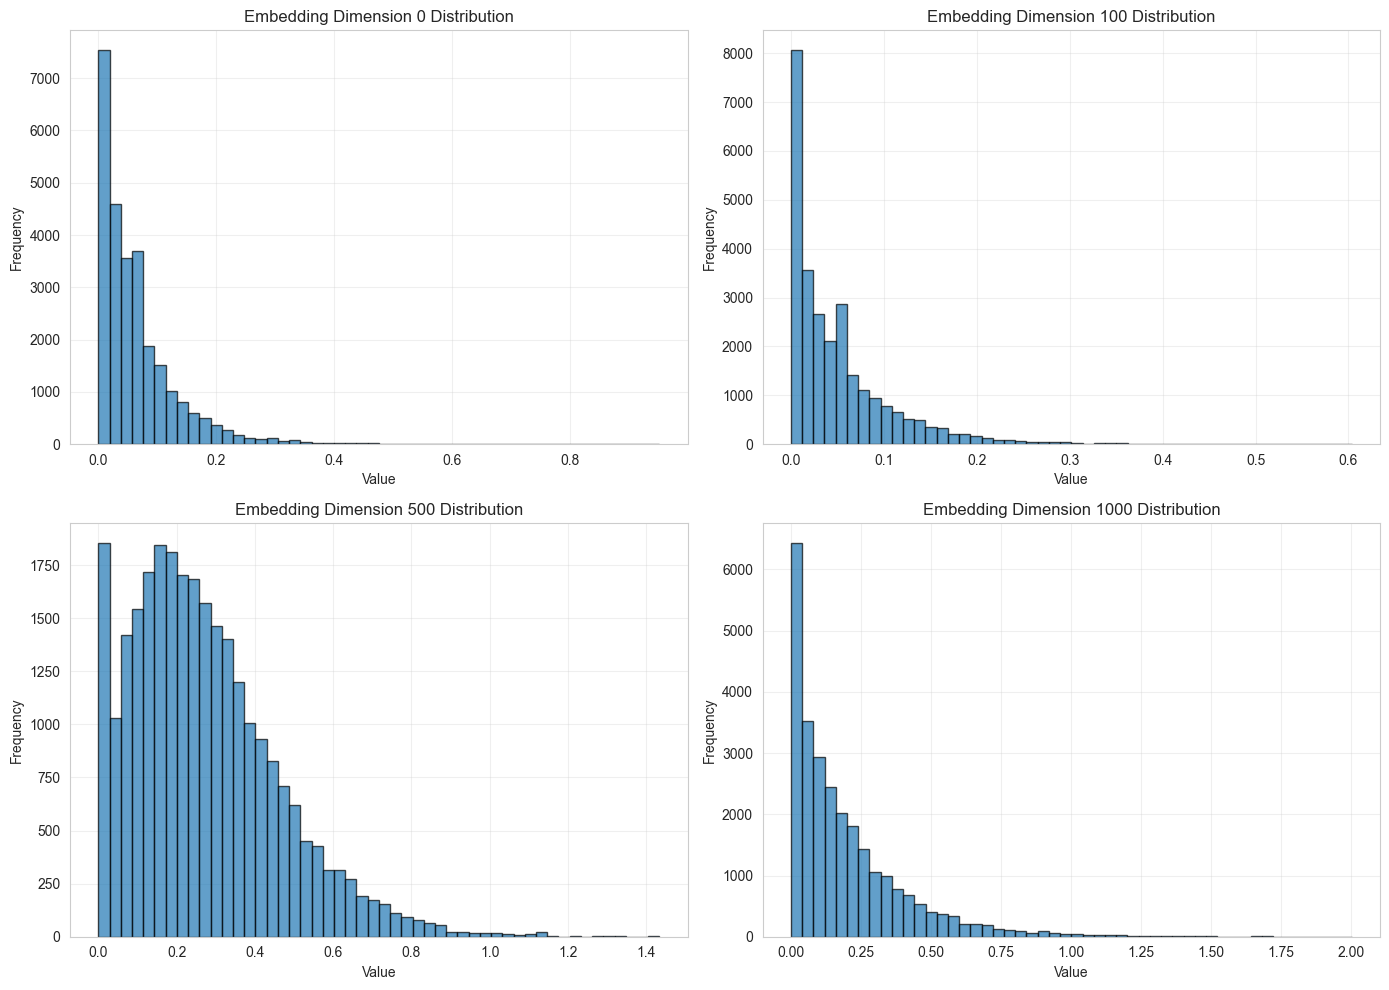

In [13]:
# Distribution of embedding values (sample)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sample a few embedding dimensions
sample_dims = [0, 100, 500, 1000]
for idx, dim in enumerate(sample_dims):
    if dim < len(embedding_cols):
        ax = axes[idx // 2, idx % 2]
        col = embedding_cols[dim]
        ax.hist(df[col].values, bins=50, alpha=0.7, edgecolor='black')
        ax.set_title(f'Embedding Dimension {dim} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


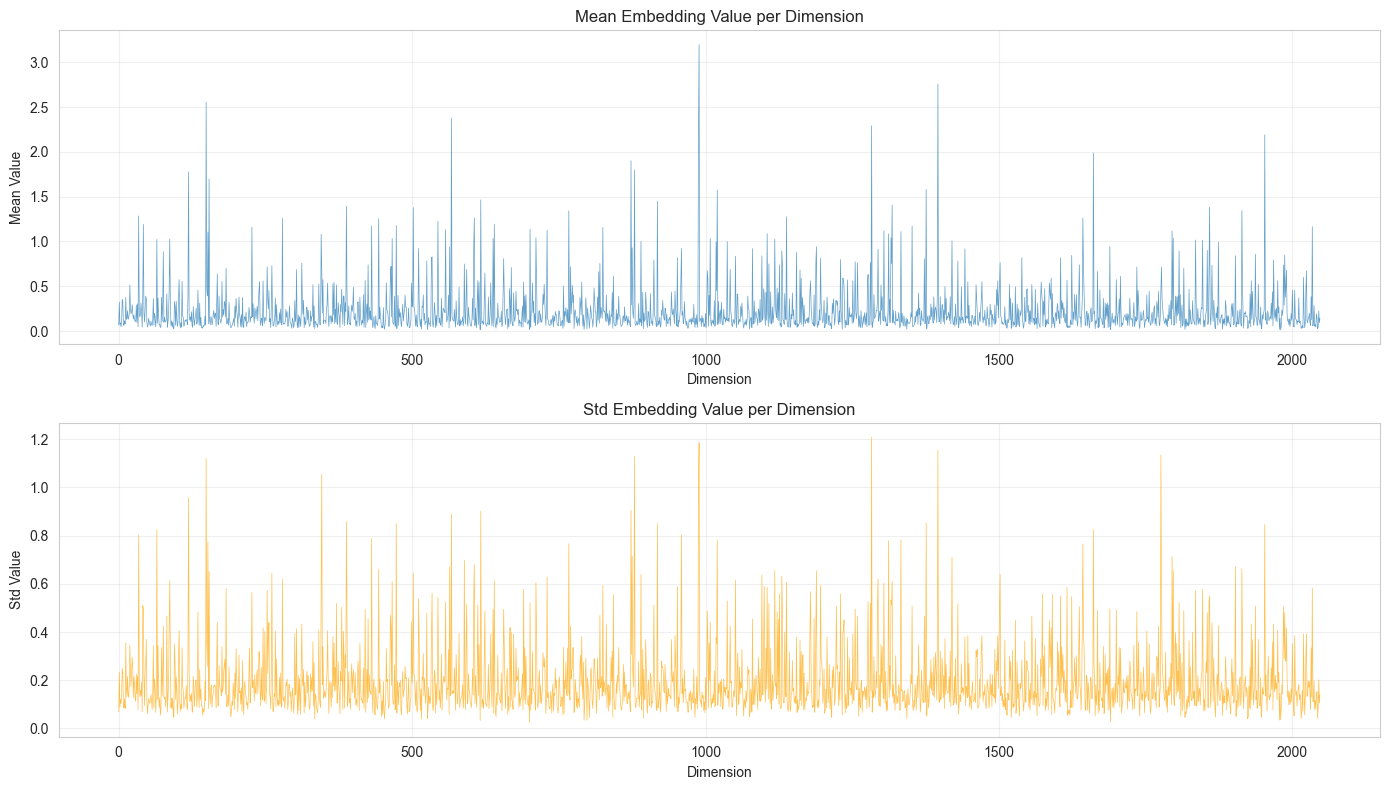

In [14]:
# Mean embedding value per dimension
mean_embeddings = embedding_matrix.mean(axis=0)
std_embeddings = embedding_matrix.std(axis=0)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Mean values
axes[0].plot(mean_embeddings, alpha=0.7, linewidth=0.5)
axes[0].set_title('Mean Embedding Value per Dimension')
axes[0].set_xlabel('Dimension')
axes[0].set_ylabel('Mean Value')
axes[0].grid(True, alpha=0.3)

# Std values
axes[1].plot(std_embeddings, alpha=0.7, linewidth=0.5, color='orange')
axes[1].set_title('Std Embedding Value per Dimension')
axes[1].set_xlabel('Dimension')
axes[1].set_ylabel('Std Value')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


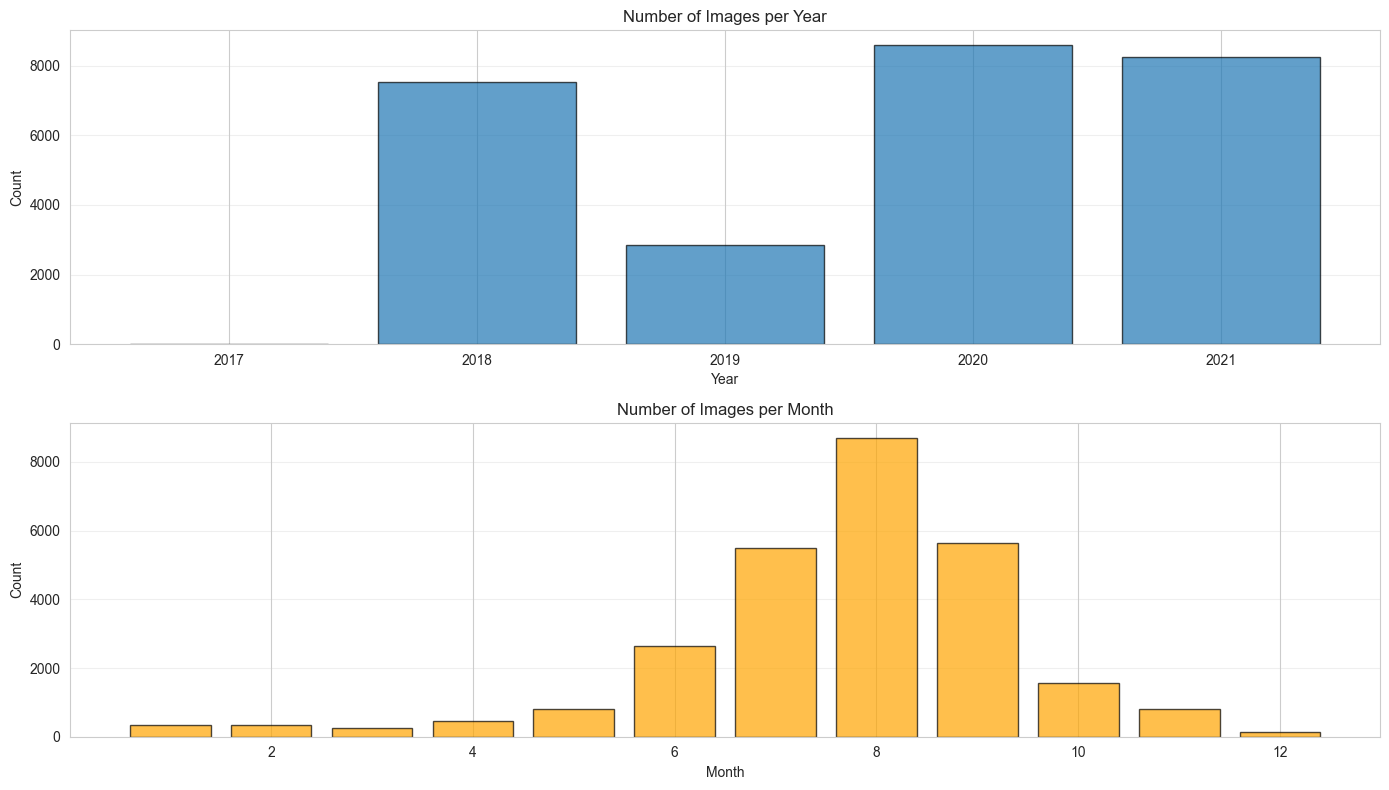

In [15]:
# Date distribution (if available)
if 'date' in df.columns and df['date'].notna().sum() > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Year distribution
    year_counts = df['year'].value_counts().sort_index()
    axes[0].bar(year_counts.index, year_counts.values, alpha=0.7, edgecolor='black')
    axes[0].set_title('Number of Images per Year')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Count')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Month distribution
    month_counts = df['month'].value_counts().sort_index()
    axes[1].bar(month_counts.index, month_counts.values, alpha=0.7, edgecolor='black', color='orange')
    axes[1].set_title('Number of Images per Month')
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel('Count')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("No date information available for visualization")


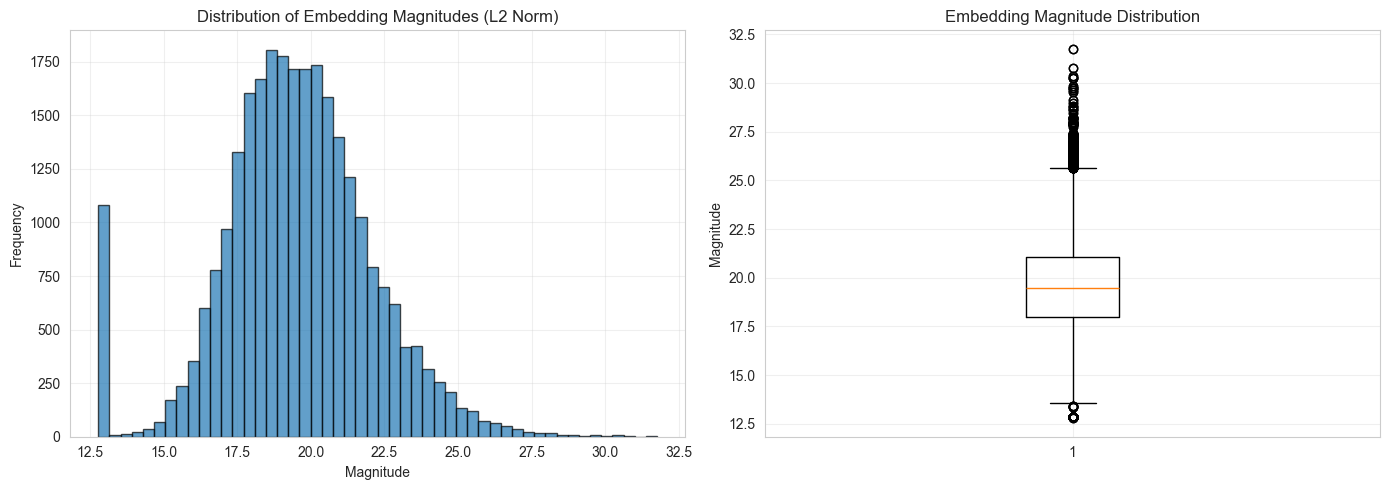

Magnitude statistics:
  Mean: 19.5050
  Std: 2.5946
  Min: 12.7827
  Max: 31.7588


In [16]:
# Embedding magnitude (L2 norm) distribution
embedding_norms = np.linalg.norm(embedding_matrix, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(embedding_norms, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Embedding Magnitudes (L2 Norm)')
axes[0].set_xlabel('Magnitude')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(embedding_norms, vert=True)
axes[1].set_title('Embedding Magnitude Distribution')
axes[1].set_ylabel('Magnitude')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Magnitude statistics:")
print(f"  Mean: {embedding_norms.mean():.4f}")
print(f"  Std: {embedding_norms.std():.4f}")
print(f"  Min: {embedding_norms.min():.4f}")
print(f"  Max: {embedding_norms.max():.4f}")


## 6. Data Quality Checks


In [17]:
# Check for duplicates
print("="*70)
print("DATA QUALITY CHECKS")
print("="*70)

# Duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows:,}")

# Duplicate filenames
if 'filename' in df.columns:
    duplicate_filenames = df['filename'].duplicated().sum()
    print(f"Duplicate filenames: {duplicate_filenames:,}")

# Missing values in metadata
print(f"\nMissing values in metadata:")
missing_meta = df[metadata_cols].isna().sum()
print(missing_meta[missing_meta > 0] if missing_meta.sum() > 0 else "  ✓ No missing values")


DATA QUALITY CHECKS
Duplicate rows: 14,073
Duplicate filenames: 26,094

Missing values in metadata:
event_id    27214
tile        27214
dtype: int64


In [18]:
# Check embedding ranges
print("="*70)
print("EMBEDDING RANGE ANALYSIS")
print("="*70)

# Check for extreme values
extreme_high = (embedding_matrix > 100).sum()
extreme_low = (embedding_matrix < -100).sum()

print(f"Values > 100: {extreme_high:,}")
print(f"Values < -100: {extreme_low:,}")

# Check for zeros
zero_count = (embedding_matrix == 0).sum()
zero_pct = (zero_count / embedding_matrix.size) * 100
print(f"\nZero values: {zero_count:,} ({zero_pct:.2f}%)")

# Check for constant dimensions
constant_dims = []
for i, col in enumerate(embedding_cols):
    if df[col].nunique() == 1:
        constant_dims.append(i)

if constant_dims:
    print(f"\n⚠️  Constant dimensions (all same value): {len(constant_dims)}")
    print(f"  Dimensions: {constant_dims[:10]}..." if len(constant_dims) > 10 else f"  Dimensions: {constant_dims}")
else:
    print(f"\n✓ No constant dimensions")


EMBEDDING RANGE ANALYSIS
Values > 100: 0
Values < -100: 0

Zero values: 2,950,194 (5.29%)

✓ No constant dimensions


## 7. Sample Data


In [19]:
# Display sample rows
print("="*70)
print("SAMPLE DATA (First 5 rows)")
print("="*70)
print(df[metadata_cols].head())


SAMPLE DATA (First 5 rows)
         filename       date event_id  tile
0  2018-01-01.tif 2018-01-01     None  None
1  2018-01-02.tif 2018-01-02     None  None
2  2018-01-03.tif 2018-01-03     None  None
3  2018-01-04.tif 2018-01-04     None  None
4  2018-01-05.tif 2018-01-05     None  None


In [20]:
# Sample embedding values (first row, first 20 dimensions)
print("="*70)
print("SAMPLE EMBEDDING VALUES (First row, first 20 dimensions)")
print("="*70)
sample_emb = df[embedding_cols[:20]].iloc[0]
print(sample_emb)


SAMPLE EMBEDDING VALUES (First row, first 20 dimensions)
embedding_0     0.011584
embedding_1     0.151510
embedding_2     0.007987
embedding_3     0.010053
embedding_4     0.000000
embedding_5     0.021731
embedding_6     0.456058
embedding_7     0.439447
embedding_8     0.000385
embedding_9     0.007056
embedding_10    0.022956
embedding_11    0.030858
embedding_12    0.244816
embedding_13    0.056764
embedding_14    0.038474
embedding_15    0.159740
embedding_16    0.012945
embedding_17    0.227292
embedding_18    0.082458
embedding_19    1.306963
Name: 0, dtype: float32


## 8. Summary


In [21]:
print("="*70)
print("EXPLORATION SUMMARY")
print("="*70)
print(f"\nDataset:")
print(f"  Total samples: {len(df):,}")
print(f"  Embedding dimensions: {len(embedding_cols)}")
print(f"  Metadata columns: {len(metadata_cols)}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nEmbeddings:")
print(f"  Shape: {embedding_matrix.shape}")
print(f"  Value range: [{embedding_matrix.min():.4f}, {embedding_matrix.max():.4f}]")
print(f"  Mean: {embedding_matrix.mean():.4f}")
print(f"  Std: {embedding_matrix.std():.4f}")
print(f"  Missing values: {df[embedding_cols].isna().sum().sum():,}")

if 'date' in df.columns and df['date'].notna().sum() > 0:
    print(f"\nTemporal coverage:")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Years: {df['year'].nunique()}")
    print(f"  Unique dates: {df['date'].nunique():,}")

if 'event_id' in df.columns:
    print(f"\nEvents:")
    print(f"  Unique events: {df['event_id'].nunique():,}")
    print(f"  Images per event (mean): {df['event_id'].value_counts().mean():.2f}")

print(f"\n" + "="*70)
print("✓ Embeddings ready for feature preparation!")
print("  Next step: python src/data/prepare_wildfirespreadts_features.py")
print("="*70)


EXPLORATION SUMMARY

Dataset:
  Total samples: 27,214
  Embedding dimensions: 2048
  Metadata columns: 4
  Memory usage: 215.91 MB

Embeddings:
  Shape: (27214, 2048)
  Value range: [0.0000, 7.6501]
  Mean: 0.2279
  Std: 0.3703
  Missing values: 0

Temporal coverage:
  Date range: 2017-12-29 00:00:00 to 2021-11-08 00:00:00
  Years: 5
  Unique dates: 1,120

Events:
  Unique events: 0
  Images per event (mean): nan

✓ Embeddings ready for feature preparation!
  Next step: python src/data/prepare_wildfirespreadts_features.py
